# <font color='orange'> imports </font>

In [1]:
import tensorflow as tf
tf.random.set_seed(404)
from numpy.random import seed
seed(888)

In [2]:
import os
import numpy as np
import itertools
import keras
from keras.datasets import cifar10
from keras.utils import array_to_img
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard

from time import strftime

from sklearn.metrics import confusion_matrix

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

# <font color='orange'>Get the Data</font>


### <font color='red'>remember remove dataset zip file from cache after all your job get done :)</font>

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

# <font color = 'orange'> Constants </font>

In [36]:
LOG_DIR = '/ImageClassification/tensorboard_cifar10_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
NR_CLASSES = 10
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000
SAMPLES_PER_BATCH = 1000
NR_EPOCHS = 150

# <font color='orange'> Explore the Data </font>


### <font color='pink' size='4'> The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images </font>

In [5]:
nr_train_images, tr_x, tr_y, tr_c = x_train_all.shape
print (f'train images = {nr_train_images} \t | width = {tr_x} \t | height = {tr_y} \t | channels = {tr_c}')
nr_test_images, ts_x, ts_y, ts_c = x_test.shape
print (f'test images = {nr_test_images} \t | width = {ts_x} \t | height = {ts_y} \t | channels = {ts_c}')

train images = 50000 	 | width = 32 	 | height = 32 	 | channels = 3
test images = 10000 	 | width = 32 	 | height = 32 	 | channels = 3


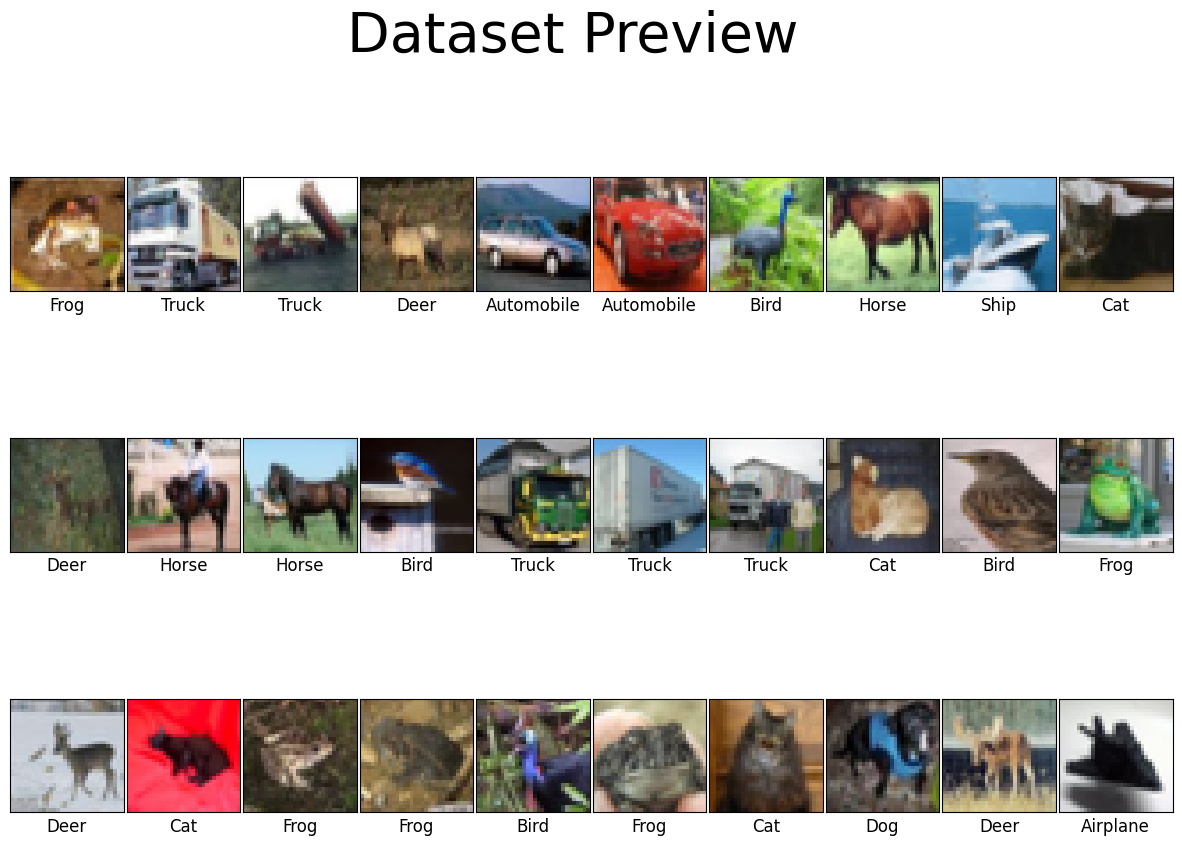

In [6]:
plt.figure(figsize=(15, 10))
plt.suptitle("Dataset Preview", fontsize=40)
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_all[i])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=12)
plt.subplots_adjust(wspace=0.025, hspace=0.05)

# <font color='orange'> Preprocess Data </font>

### <font color='pink'> downscaling number range from  (unint8: 0..255)  to  (float64: 0..1) </font>
### <font color='pink'> after that its much easier to calculate loss function and adjust weight and ... </font>

In [7]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0

### <font color='pink'> reshaping dataset from (number of imgs, row, column, channel) to (number of imgs, TOTAL_INPUTS)</font>

In [8]:
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)
print(f'Shape of x_train_all is {x_train_all.shape}')

x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_train_all is (50000, 3072)
Shape of x_test is (10000, 3072)


### <font color='pink'> create validation dataset from train dataset </font>

In [9]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

x_train = x_train_all[VALIDATION_SIZE:] 
y_train = y_train_all[VALIDATION_SIZE:]

### <font color='pink'> create a small dataset (for illustration) </font>

In [10]:
x_train_small = x_train[:SMALL_TRAIN_SIZE]
y_train_small = y_train[:SMALL_TRAIN_SIZE]

# <font color='orange'> Define the Neural Netwrok (Multi Layer Percepteron) using Keras </font>

### <font color='pink'> Define and Compiling - model 1 - without Regularization </font>

In [11]:
model_1 = Sequential([
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden_1'),
    Dense(units=64, activation='relu', name='m1_hidden_2'),
    Dense(units=16, activation='relu', name='m1_hidden_3'),
    Dense(10, activation='softmax', name='m1_output')
])

model_1.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
# optimizer="adam", loss = tf.keras.losses.SparseCategoricalCrossentropy

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-02-25 19:07:15.243605: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-25 19:07:15.243659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### <font color='pink'> m1_hidden_1 Param: 393,344 == W:32 * H:32 * C:3 * neurons:128 + bias:128 </font>

#### <font color='pink'> Total params: 402,810 == (32 * 32 * 3 * 128 + 128) + (128 * 64 + 64) + (64 * 16 + 16) + (16 * 10 + 10) </font>

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden_1 (Dense)         (None, 128)               393344    
                                                                 
 m1_hidden_2 (Dense)         (None, 64)                8256      
                                                                 
 m1_hidden_3 (Dense)         (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


### <font color='pink'> Define and Compile - moodel 2 - using 1 layer Drop out (Regularization)</font>

In [13]:
model_2 = Sequential([
    Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)),
    Dense(units=128, activation='relu', name='m2_hidden_1'),
    Dense(units=64, activation='relu', name='m2_hidden_2'),
    Dense(units=16, activation='relu', name='m2_hidden_3'),
    Dense(units=10, activation='softmax', name='m2_output')
])

model_2.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 3072)              0         
                                                                 
 m2_hidden_1 (Dense)         (None, 128)               393344    
                                                                 
 m2_hidden_2 (Dense)         (None, 64)                8256      
                                                                 
 m2_hidden_3 (Dense)         (None, 16)                1040      
                                                                 
 m2_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


### <font color='pink'> Define and Compile - moodel 3 - using 2 layer Drop out (Regularization) </font>

In [14]:
model_3 = Sequential()
model_3.add(Dropout(rate=0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(units=128, activation='relu', name='m3_hidden_1'))
model_3.add(Dropout(rate=0.25, seed=42))
model_3.add(Dense(units=128, activation='relu', name='m3_hidden_2'))
model_3.add(Dense(units=128, activation='relu', name='m3_hidden_3'))
model_3.add(Dense(units=128, activation='softmax', name='m3_output'))

model_3.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         (None, 3072)              0         
                                                                 
 m3_hidden_1 (Dense)         (None, 128)               393344    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 m3_hidden_2 (Dense)         (None, 128)               16512     
                                                                 
 m3_hidden_3 (Dense)         (None, 128)               16512     
                                                                 
 m3_output (Dense)           (None, 128)               16512     
                                                                 
Total params: 442,880
Trainable params: 442,880
Non-tr

# <font color='orange'> Tensorboard (Visualising Learning) </font>

### <font color='pink'> setting tensorboard folder for write and read log files </font>

In [15]:
def get_tensorboard(model_name):
    folder_name = f"{model_name} at {strftime('(%H-%M)')}"
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory')

    return TensorBoard(log_dir=dir_paths)

# <font color='orange'> Fit the Model </font>

### <font color='pink'> model 1 - trainig on a small batch of train dateset (1,000 imgs) - validation with all val dataset (10,000)</font>

In [16]:
%%time

model_1.fit(x = x_train_small, 
            y = y_train_small, 
            batch_size = SAMPLES_PER_BATCH, 
            epochs = NR_EPOCHS, 
            callbacks = [get_tensorboard("model 1 S")], 
            verbose = 1, 
            validation_data = (x_val, y_val))

Successfully created directory
Epoch 1/150


2023-02-25 19:09:35.844266: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-25 19:09:36.011671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 943ms/step - loss: 2.3265 - accuracy: 0.0930 - val_loss: 2.3575 - val_accuracy: 0.1346
Epoch 2/150
1/1 [==============================] - ETA: 0s - loss: 2.3400 - accuracy: 0.1500

2023-02-25 19:09:36.674863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 103ms/step - loss: 2.3400 - accuracy: 0.1500 - val_loss: 2.3409 - val_accuracy: 0.0944
Epoch 3/150
1/1 [==============================] - 0s 100ms/step - loss: 2.3222 - accuracy: 0.1020 - val_loss: 2.3759 - val_accuracy: 0.1028
Epoch 4/150
1/1 [==============================] - 0s 95ms/step - loss: 2.3693 - accuracy: 0.1020 - val_loss: 2.3100 - val_accuracy: 0.1514
Epoch 5/150
1/1 [==============================] - 0s 94ms/step - loss: 2.3103 - accuracy: 0.1320 - val_loss: 2.3048 - val_accuracy: 0.1371
Epoch 6/150
1/1 [==============================] - 0s 94ms/step - loss: 2.3131 - accuracy: 0.1270 - val_loss: 2.2829 - val_accuracy: 0.1500
Epoch 7/150
1/1 [==============================] - 0s 96ms/step - loss: 2.2858 - accuracy: 0.1420 - val_loss: 2.2749 - val_accuracy: 0.1304
Epoch 8/150
1/1 [==============================] - 0s 95ms/step - loss: 2.2736 - accuracy: 0.1150 - val_loss: 2.2743 - val_accuracy: 0.0976
Epoch 9/150
1/1 [=============

### <font color='pink'> model 2 -  trainig on all train dateset (40,000 imgs) - validation with all val dataset (10,000) </font>

In [17]:
%%time

model_2.fit(x=x_train, 
            y=y_train, 
            batch_size=SAMPLES_PER_BATCH, 
            epochs=NR_EPOCHS, 
            callbacks=[get_tensorboard("model 2 L")], 
            verbose=1, 
            validation_data=(x_val, y_val))

Successfully created directory
Epoch 1/150


2023-02-25 19:10:56.694527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 16ms/step - loss: 2.2559 - accuracy: 0.1410 - val_loss: 2.1944 - val_accuracy: 0.1809
Epoch 2/150
 6/40 [===>..........................] - ETA: 0s - loss: 2.1897 - accuracy: 0.1783

2023-02-25 19:10:57.434579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 11ms/step - loss: 2.1432 - accuracy: 0.1921 - val_loss: 2.0831 - val_accuracy: 0.2164
Epoch 3/150
40/40 [==============================] - 0s 11ms/step - loss: 2.0619 - accuracy: 0.2312 - val_loss: 2.0549 - val_accuracy: 0.2306
Epoch 4/150
40/40 [==============================] - 0s 12ms/step - loss: 2.0052 - accuracy: 0.2585 - val_loss: 1.9569 - val_accuracy: 0.2872
Epoch 5/150
40/40 [==============================] - 0s 12ms/step - loss: 1.9150 - accuracy: 0.2982 - val_loss: 1.8319 - val_accuracy: 0.3422
Epoch 6/150
40/40 [==============================] - 0s 12ms/step - loss: 1.8270 - accuracy: 0.3389 - val_loss: 1.7719 - val_accuracy: 0.3603
Epoch 7/150
40/40 [==============================] - 0s 11ms/step - loss: 1.7743 - accuracy: 0.3613 - val_loss: 1.7193 - val_accuracy: 0.3736
Epoch 8/150
40/40 [==============================] - 0s 11ms/step - loss: 1.7349 - accuracy: 0.3769 - val_loss: 1.7107 - val_accuracy: 0.3798
Epoch 9/150
40/40 

### <font color='pink'> model 3 - trainig on all train dateset (40,000 imgs) - validation with all val dataset (10,000) </font>

In [18]:
%%time

model_3.fit(x=x_train, 
            y=y_train, 
            batch_size=SAMPLES_PER_BATCH, 
            epochs=NR_EPOCHS, 
            callbacks=[get_tensorboard("model 3 L")], 
            verbose=1, 
            validation_data=(x_val, y_val))

Successfully created directory
Epoch 1/150
 1/40 [..............................] - ETA: 11s - loss: 4.7320 - accuracy: 0.0260

2023-02-25 19:12:34.578280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 17ms/step - loss: 2.4650 - accuracy: 0.1599 - val_loss: 2.0310 - val_accuracy: 0.2565
Epoch 2/150
 6/40 [===>..........................] - ETA: 0s - loss: 2.0745 - accuracy: 0.2327

2023-02-25 19:12:35.242364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 0s 12ms/step - loss: 2.0084 - accuracy: 0.2661 - val_loss: 1.9074 - val_accuracy: 0.3047
Epoch 3/150
40/40 [==============================] - 0s 12ms/step - loss: 1.9230 - accuracy: 0.3077 - val_loss: 1.8350 - val_accuracy: 0.3428
Epoch 4/150
40/40 [==============================] - 0s 12ms/step - loss: 1.8628 - accuracy: 0.3340 - val_loss: 1.7881 - val_accuracy: 0.3596
Epoch 5/150
40/40 [==============================] - 1s 15ms/step - loss: 1.8262 - accuracy: 0.3448 - val_loss: 1.7395 - val_accuracy: 0.3732
Epoch 6/150
40/40 [==============================] - 1s 15ms/step - loss: 1.7788 - accuracy: 0.3642 - val_loss: 1.6915 - val_accuracy: 0.3948
Epoch 7/150
40/40 [==============================] - 1s 13ms/step - loss: 1.7432 - accuracy: 0.3743 - val_loss: 1.6663 - val_accuracy: 0.3952
Epoch 8/150
40/40 [==============================] - 0s 12ms/step - loss: 1.7155 - accuracy: 0.3870 - val_loss: 1.6362 - val_accuracy: 0.4101
Epoch 9/150
40/40 

# <font color='orange'> Predictions on Individual Images </font>

In [21]:
def prediction(model, x_val, y_val):
    for number in range(10):
        test_img = np.expand_dims(x_val[number], axis=0)
        # predicted_val = model.predict_classes(test_img)[0]
        predict_x=model.predict(test_img) 
        classes_x=np.argmax(predict_x,axis=1)
        print (f'Actual value: {y_val[number][0]} vs. predicted: {classes_x}')

### <font color='pink'> Prediction of model 1 after training </font>

In [22]:
prediction(model_1, x_val, y_val)

2023-02-25 19:21:06.453361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 408ms/step
Actual value: 6 vs. predicted: [4]
1/1 [==============================] - 0s 13ms/step
Actual value: 9 vs. predicted: [0]
1/1 [==============================] - 0s 14ms/step
Actual value: 9 vs. predicted: [9]
1/1 [==============================] - 0s 13ms/step
Actual value: 4 vs. predicted: [4]
1/1 [==============================] - 0s 13ms/step
Actual value: 1 vs. predicted: [8]
1/1 [==============================] - 0s 13ms/step
Actual value: 1 vs. predicted: [7]
1/1 [==============================] - 0s 13ms/step
Actual value: 2 vs. predicted: [4]
1/1 [==============================] - 0s 17ms/step
Actual value: 7 vs. predicted: [4]
1/1 [==============================] - 0s 14ms/step
Actual value: 8 vs. predicted: [8]
1/1 [==============================] - 0s 13ms/step
Actual value: 3 vs. predicted: [9]


### <font color='pink'> Prediction of model 2 after training </font>

In [23]:
prediction(model_2, x_val, y_val)

1/1 [==============================] - 0s 47ms/step
Actual value: 6 vs. predicted: [6]
1/1 [==============================] - 0s 22ms/step
Actual value: 9 vs. predicted: [1]
1/1 [==============================] - 0s 13ms/step
Actual value: 9 vs. predicted: [9]
1/1 [==============================] - 0s 13ms/step
Actual value: 4 vs. predicted: [6]
1/1 [==============================] - 0s 13ms/step
Actual value: 1 vs. predicted: [1]
1/1 [==============================] - 0s 13ms/step


2023-02-25 19:21:22.079680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Actual value: 1 vs. predicted: [7]
1/1 [==============================] - 0s 13ms/step
Actual value: 2 vs. predicted: [2]
1/1 [==============================] - 0s 13ms/step
Actual value: 7 vs. predicted: [7]
1/1 [==============================] - 0s 13ms/step
Actual value: 8 vs. predicted: [8]
1/1 [==============================] - 0s 13ms/step
Actual value: 3 vs. predicted: [4]


### <font color='pink'> Prediction of model 3 after training </font>

In [24]:
prediction(model_3, x_val, y_val)

1/1 [==============================] - 0s 51ms/step
Actual value: 6 vs. predicted: [2]
1/1 [==============================] - 0s 13ms/step
Actual value: 9 vs. predicted: [1]
1/1 [==============================] - 0s 12ms/step
Actual value: 9 vs. predicted: [9]
1/1 [==============================] - 0s 17ms/step
Actual value: 4 vs. predicted: [6]
1/1 [==============================] - 0s 15ms/step
Actual value: 1 vs. predicted: [8]
1/1 [==============================] - 0s 13ms/step


2023-02-25 19:21:36.288851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Actual value: 1 vs. predicted: [3]
1/1 [==============================] - 0s 12ms/step
Actual value: 2 vs. predicted: [2]
1/1 [==============================] - 0s 13ms/step
Actual value: 7 vs. predicted: [7]
1/1 [==============================] - 0s 13ms/step
Actual value: 8 vs. predicted: [0]
1/1 [==============================] - 0s 13ms/step
Actual value: 3 vs. predicted: [9]


# <font color="orange"> Evaluation </font>

### <font color='pink'> Evaluation of the model 1 </font>

In [26]:
test_loss, test_accuracy = model_1.evaluate(x_test, y_test)
print (f'Model 1 -> Test loss is {test_loss:0.3} and test accuracy is {test_accuracy: 0.1%}')

313/313 [==============================] - 2s 6ms/step - loss: 2.1207 - accuracy: 0.2527
Model 1 -> Test loss is 2.12 and test accuracy is  25.3%


### <font color='pink'> Evaluation of the model 2 </font>

In [27]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print (f'Model 2 -> Test loss is {test_loss:0.3} and test accuracy is {test_accuracy: 0.1%}')

 19/313 [>.............................] - ETA: 1s - loss: 1.4390 - accuracy: 0.4737

2023-02-25 19:22:09.077049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 1.4494 - accuracy: 0.4978
Model 2 -> Test loss is 1.449 and test accuracy is  49.8%


### <font color='pink'> Evaluation of the model 3 </font>

In [29]:
test_loss, test_accuracy = model_3.evaluate(x_test, y_test)
print (f'Model 3 -> Test loss is {test_loss:0.3} and test accuracy is {test_accuracy: 0.1%}')

 18/313 [>.............................] - ETA: 1s - loss: 1.3852 - accuracy: 0.4948

2023-02-25 19:22:42.626821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 6ms/step - loss: 1.3455 - accuracy: 0.5257
Model 3 -> Test loss is 1.345 and test accuracy is  52.6%


# <font color='orange'> Confusion Matrix </font>

In [34]:
def confusionMatrix(model, x_test, y_test, color=plt.cm.Greens):
    predict_x=model.predict(x_test) 
    classes_x=np.argmax(predict_x,axis=1)
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=classes_x)
    nr_rows = conf_matrix.shape [0]
    nr_cols = conf_matrix.shape [1]

    plt.figure(figsize=(7, 7))
    plt.imshow(conf_matrix, cmap=color)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)
    tick_marks = np.arange(NR_CLASSES)
    plt.yticks (tick_marks, LABEL_NAMES)
    plt.xticks (tick_marks, LABEL_NAMES)
    plt.colorbar()

    for i, j in itertools.product(range(nr_rows), range(nr_cols)):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', 
            color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black' )

    plt.show()

    true_positives = np.diag(conf_matrix)
    print(f"True Positives : {true_positives}")
    recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    print(f"Recall = {recall}")
    precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    print(f"precision = {np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)}")
    avg_recall = np.mean(recall)
    print(f'Recall score is {avg_recall:.2%}')
    avg_precision = np.mean (precision)
    print (f'Precision score is {avg_precision:.2%}')
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    print (f'F Score is {f1_score:.2%}')

### <font color='pink'> model 1 - confusion matrix and evaluation metrics </font>

313/313 [==============================] - 1s 3ms/step


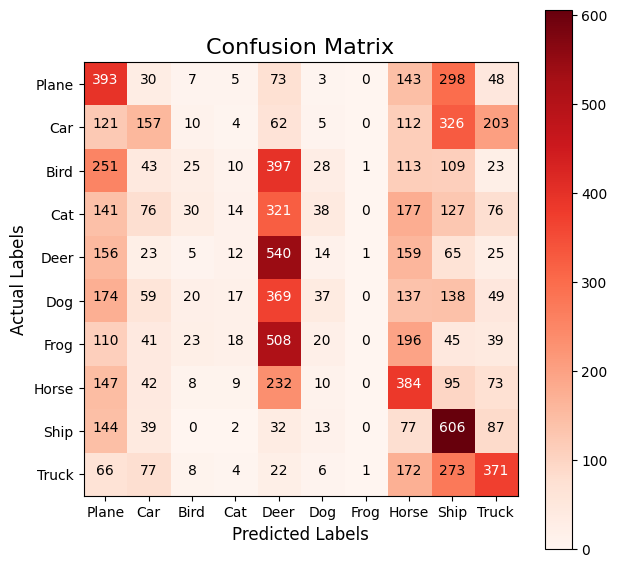

True Positives : [393 157  25  14 540  37   0 384 606 371]
Recall = [0.393 0.157 0.025 0.014 0.54  0.037 0.    0.384 0.606 0.371]
precision = [0.23076923 0.26746167 0.18382353 0.14736842 0.21126761 0.21264368
 0.         0.22994012 0.29106628 0.37323944]
Recall score is 25.27%
Precision score is 21.48%
F Score is 23.22%


In [39]:
confusionMatrix(model_1, x_test, y_test, plt.cm.Reds)

### <font color='pink'> model 2 - confusion matrix and evaluation metrics</font>

313/313 [==============================] - 1s 3ms/step


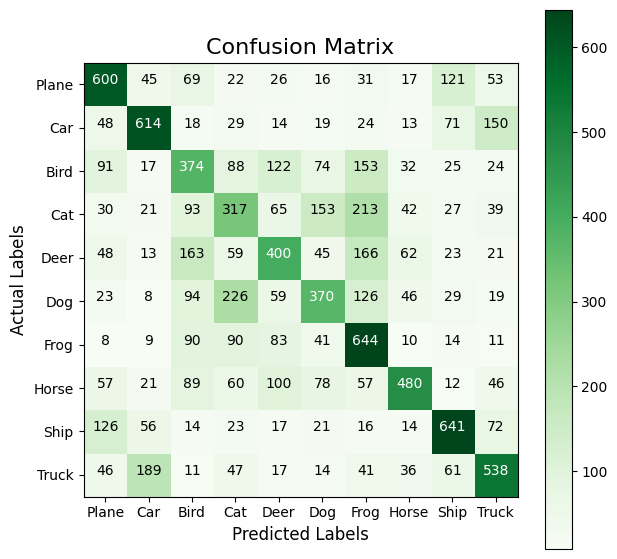

True Positives : [600 614 374 317 400 370 644 480 641 538]
Recall = [0.6   0.614 0.374 0.317 0.4   0.37  0.644 0.48  0.641 0.538]
precision = [0.55710306 0.6183283  0.36847291 0.32986472 0.44296788 0.44524669
 0.43779742 0.63829787 0.62597656 0.55292909]
Recall score is 49.78%
Precision score is 50.17%
F Score is 49.97%


In [38]:
confusionMatrix(model_2, x_test, y_test, plt.cm.Greens)

### <font color='pink'> model 3 - confusion matrix and evaluation metrics </font>

313/313 [==============================] - 1s 3ms/step


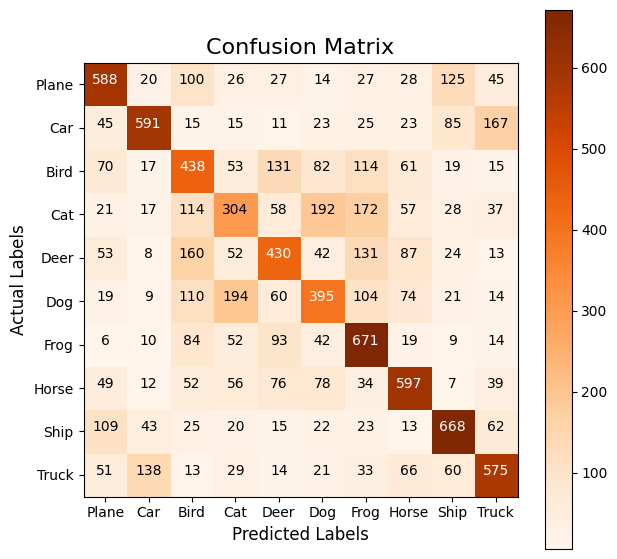

True Positives : [588 591 438 304 430 395 671 597 668 575]
Recall = [0.588 0.591 0.438 0.304 0.43  0.395 0.671 0.597 0.668 0.575]
precision = [0.58160237 0.68323699 0.39423942 0.37952559 0.46994536 0.43358946
 0.5029985  0.58243902 0.63862333 0.5861366 ]
Recall score is 52.57%
Precision score is 52.52%
F Score is 52.55%


In [37]:
confusionMatrix(model_3, x_test, y_test, plt.cm.Oranges)

# <font color='orange'> Prediction Previews </font>

In [93]:
def predict_preview(model, x_test):
    plt.figure(figsize=(15, 10))
    plt.suptitle("Prediction Preview", fontsize=40)
    predict_x=model.predict(x_test) 
    classes_x=np.argmax(predict_x,axis=1)
    for i in range(30):
        plt.subplot(3, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(array_to_img(x_test[i].reshape((32, 32, 3))))
        plt.xlabel(LABEL_NAMES[classes_x[i]], fontsize=12)
    plt.subplots_adjust(wspace=0.025, hspace=0.05)

### <font color='pink'> model 1 </font>

313/313 [==============================] - 1s 2ms/step


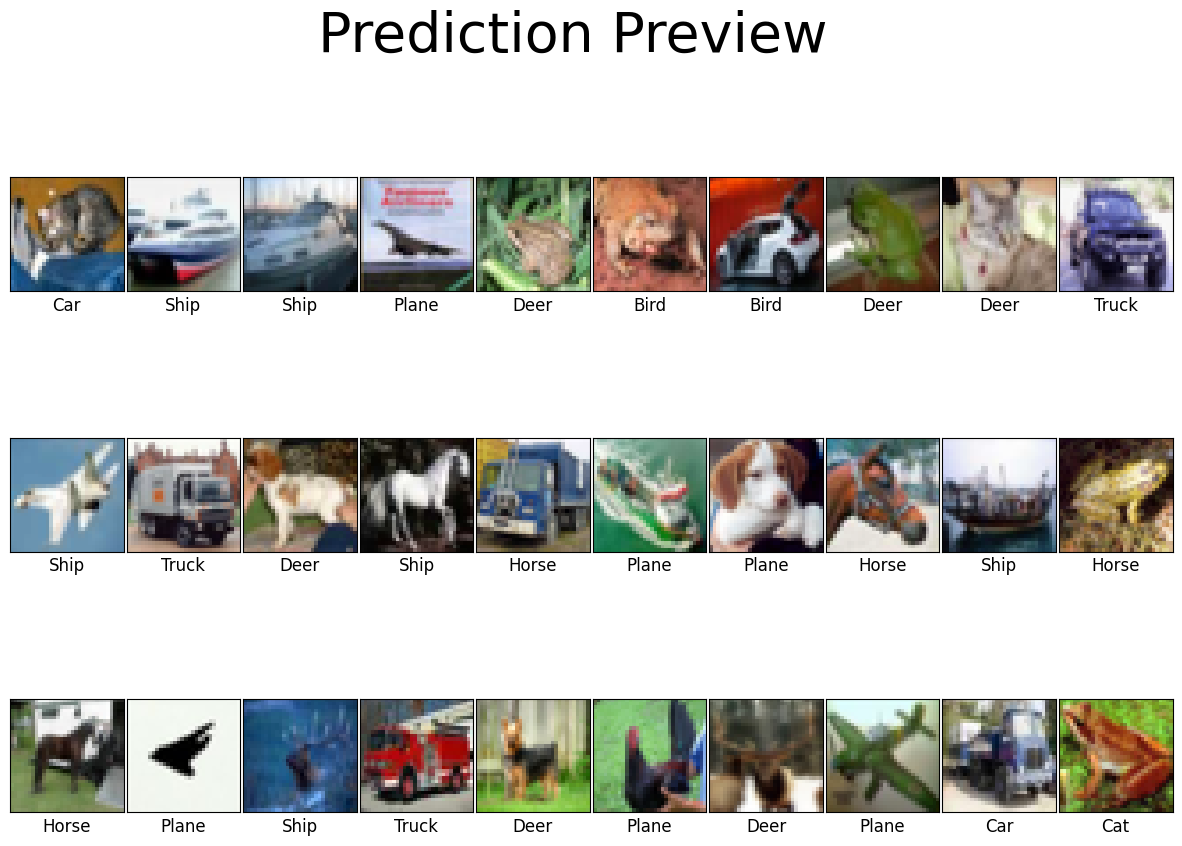

In [96]:
predict_preview(model_1, x_test)

### <font color='pink'> model 2 </font>

313/313 [==============================] - 1s 3ms/step


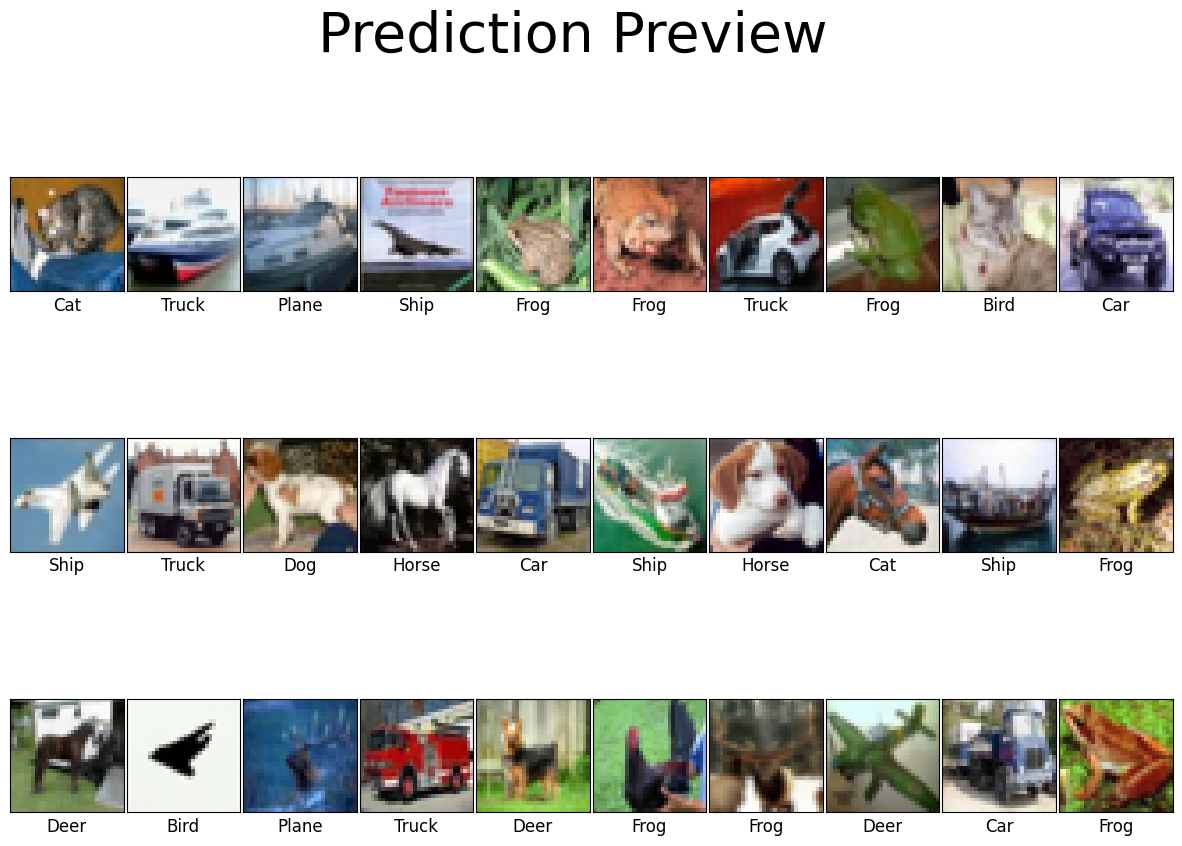

In [95]:
predict_preview(model_2, x_test)

### <font color='pink'> model 3 </font>

313/313 [==============================] - 1s 3ms/step


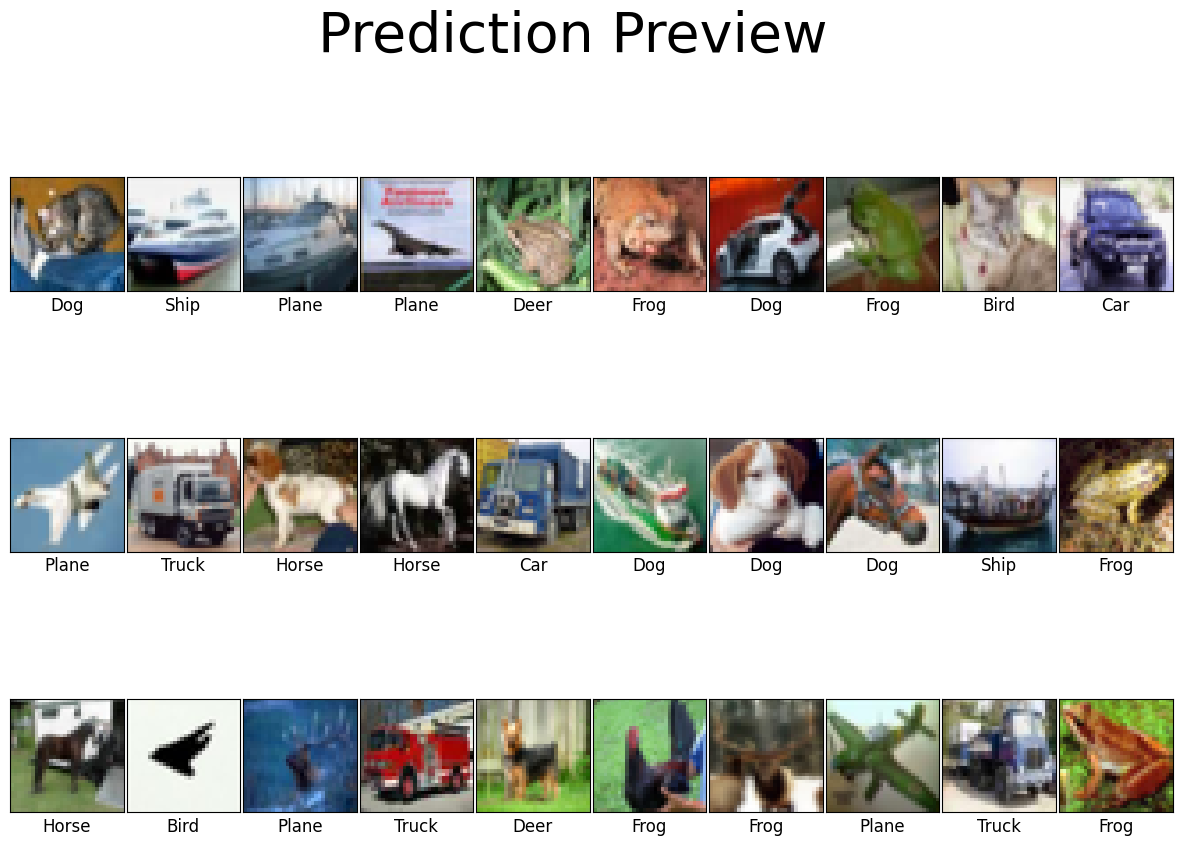

In [94]:
predict_preview(model_3, x_test)